# Importing Necessary Libraries

In [1]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
import gspread
import df2gspread as d2g
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

# Code for Google sheets API

In [2]:
from oauth2client.service_account import ServiceAccountCredentials
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']
credentials = ServiceAccountCredentials.from_json_keyfile_name('sheet_cred.json',scope)
gc = gspread.authorize(credentials)

In [3]:
plt.style.use('fivethirtyeight')

# Extracting data from Yahoo Finance

In [4]:
df = web.DataReader('AXISGOLD.NS', data_source='yahoo', start = '2020-03-01', end = '2022-10-31')
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-03-02,37.089500,36.325001,36.855000,36.834499,123000.0,36.834499
2020-03-03,37.014999,36.642502,37.000000,36.934502,70800.0,36.934502
2020-03-04,38.290001,37.673000,37.673000,38.000000,94000.0,38.000000
2020-03-05,38.119999,37.799999,38.000000,37.958000,48100.0,37.958000
2020-03-06,41.160000,38.256001,38.716999,39.585499,592200.0,39.585499
...,...,...,...,...,...,...
2022-09-02,43.950001,43.400002,43.500000,43.570000,42188.0,43.570000
2022-09-05,43.840000,43.450001,43.840000,43.630001,60512.0,43.630001
2022-09-06,43.900002,43.630001,43.660000,43.689999,25090.0,43.689999


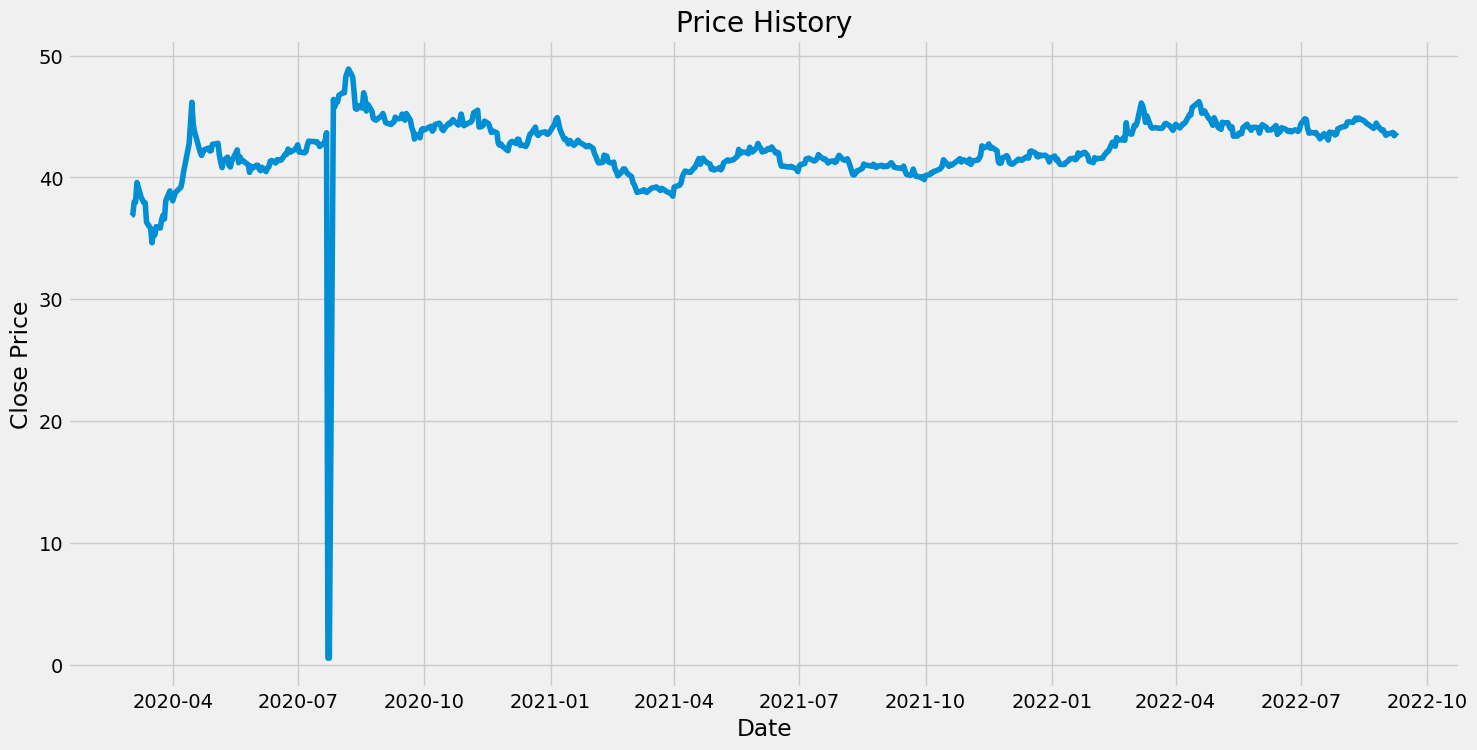

In [5]:
plt.figure(figsize = (16,8))
plt.title('Price History')
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

In [6]:
data = df.filter(['Close'])
data

,Close
Date,
2020-03-02,36.834499
2020-03-03,36.934502
2020-03-04,38.000000
2020-03-05,37.958000
2020-03-06,39.585499
...,...
2022-09-02,43.570000
2022-09-05,43.630001
2022-09-06,43.689999


In [7]:
dataset = data.values
dataset

array([[36.83449936],
       [36.93450165],
       [38.        ],
       [37.95800018],
       [39.58549881],
       [38.38399887],
       [37.92850113],
       [37.92200089],
       [36.31549835],
       [35.79999924],
       [34.63050079],
       [35.62850189],
       [35.26750183],
       [35.95500183],
       [35.8445015 ],
       [36.5340004 ],
       [36.90200043],
       [36.58449936],
       [38.08850098],
       [38.88700104],
       [38.52799988],
       [38.07849884],
       [38.76100159],
       [39.19549942],
       [39.73300171],
       [40.49000168],
       [42.77249908],
       [46.17449951],
       [44.32249832],
       [43.72750092],
       [42.47800064],
       [42.08750153],
       [41.8030014 ],
       [42.05899811],
       [42.26300049],
       [42.40250015],
       [42.17399979],
       [42.19400024],
       [42.71699905],
       [42.79550171],
       [41.83649826],
       [41.23149872],
       [40.80350113],
       [41.3844986 ],
       [41.66799927],
       [40

In [8]:
training_data_len = len(dataset) - 60
training_data_len

567

# Scaling the Data

In [9]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[-1.74366466e+00],
       [-1.71158109e+00],
       [-1.36973897e+00],
       [-1.38321370e+00],
       [-8.61065930e-01],
       [-1.24654122e+00],
       [-1.39267783e+00],
       [-1.39476330e+00],
       [-1.91017492e+00],
       [-2.07556168e+00],
       [-2.45076998e+00],
       [-2.13058289e+00],
       [-2.24640196e+00],
       [-2.02583244e+00],
       [-2.06128409e+00],
       [-1.84007326e+00],
       [-1.72200840e+00],
       [-1.82387176e+00],
       [-1.34134534e+00],
       [-1.08516385e+00],
       [-1.20034161e+00],
       [-1.34455431e+00],
       [-1.12558805e+00],
       [-9.86188807e-01],
       [-8.13742812e-01],
       [-5.70875728e-01],
       [ 1.61414247e-01],
       [ 1.25287258e+00],
       [ 6.58698012e-01],
       [ 4.67805950e-01],
       [ 6.69307850e-02],
       [-5.83524186e-02],
       [-1.49628136e-01],
       [-6.74971244e-02],
       [-2.04736849e-03],
       [ 4.27080847e-02],
       [-3.06013207e-02],
       [-2.41846060e-02],
       [ 1.4

In [10]:
train_data = scaled_data[0:training_data_len, :]
X_train = []
y_train = []
for i in range(60,len(train_data)):
    X_train.append(train_data[i-60 : i, 0])
    y_train.append(train_data[i, 0])

# Creatig Training Dataset
- The features are past 60 values of Closing Price
- The label is the Closing price for that particular day.

In [11]:
X_train

[array([-1.74366466e+00, -1.71158109e+00, -1.36973897e+00, -1.38321370e+00,
        -8.61065930e-01, -1.24654122e+00, -1.39267783e+00, -1.39476330e+00,
        -1.91017492e+00, -2.07556168e+00, -2.45076998e+00, -2.13058289e+00,
        -2.24640196e+00, -2.02583244e+00, -2.06128409e+00, -1.84007326e+00,
        -1.72200840e+00, -1.82387176e+00, -1.34134534e+00, -1.08516385e+00,
        -1.20034161e+00, -1.34455431e+00, -1.12558805e+00, -9.86188807e-01,
        -8.13742812e-01, -5.70875728e-01,  1.61414247e-01,  1.25287258e+00,
         6.58698012e-01,  4.67805950e-01,  6.69307850e-02, -5.83524186e-02,
        -1.49628136e-01, -6.74971244e-02, -2.04736849e-03,  4.27080847e-02,
        -3.06013207e-02, -2.41846060e-02,  1.43608262e-01,  1.68794143e-01,
        -1.38881393e-01, -3.32982424e-01, -4.70296203e-01, -2.83895719e-01,
        -1.92940654e-01, -4.10783407e-01, -4.53453397e-01, -2.90953738e-01,
        -2.31439719e-01, -3.01054883e-03, -3.40361095e-01, -1.83797172e-01,
        -2.9

In [12]:
y_train

[-0.5152119819629569,
 -0.5501826488743019,
 -0.4616336990468493,
 -0.5745656752925397,
 -0.47607161314893987,
 -0.45313274529986947,
 -0.30234300886769366,
 -0.2834135168428538,
 -0.3491839248996775,
 -0.2604746489937834,
 -0.28614150790274706,
 -0.26833552229019164,
 -0.2728271002129409,
 -0.11225257754305935,
 -0.11754578585801584,
 0.018645710393627894,
 -0.06589263974639989,
 -0.05482402101796831,
 0.010303858861895294,
 0.055541514109464556,
 0.1307748323839168,
 -0.05835241860687457,
 -0.061561387902092125,
 -0.08113218424069776,
 -0.0442363805248611,
 0.11858393110639501,
 0.22702432942933617,
 0.2212489190158611,
 0.21804117358383776,
 0.20183844875569693,
 0.2129070674841285,
 0.15676234344976334,
 0.08634125525494322,
 0.1750493072976431,
 0.24466998896345013,
 0.44967931262549937,
 -13.393264234297286,
 -13.393264234297286,
 1.3252200269942958,
 1.1327222567666513,
 1.2610541035850809,
 1.2610541035850809,
 1.4375094750630262,
 1.501675398472241,
 1.501675398472241,
 1.9187

In [13]:
X_train , y_train = np.array(X_train), np.array(y_train)

In [14]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(507, 60, 1)

# Creating LSTM model with mutiple layers
- The first layer is made up of 50 neurons
- The second layer is also made up of 50 neurons
- The third layer is a hidden layer and is made up of 25 neurons
- The fourth is the ouput layer and consists of a single neuron which give us the predicted value.

In [15]:
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape = (X_train.shape[1], 1)))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [16]:
model.compile(optimizer = 'adam', loss= 'mean_squared_error')

# Cross Validation

In [17]:
model.fit(X_train, y_train, batch_size= 15, epochs = 15)

Epoch 1/15
34/34 [==============================] - 5s 32ms/step - loss: 0.8455
Epoch 2/15
34/34 [==============================] - 1s 32ms/step - loss: 0.7730
Epoch 3/15
34/34 [==============================] - 1s 32ms/step - loss: 0.7551
Epoch 4/15
34/34 [==============================] - 1s 32ms/step - loss: 0.7460
Epoch 5/15
34/34 [==============================] - 1s 32ms/step - loss: 0.7343
Epoch 6/15
34/34 [==============================] - 1s 32ms/step - loss: 0.7238
Epoch 7/15
34/34 [==============================] - 1s 32ms/step - loss: 0.7138
Epoch 8/15
34/34 [==============================] - 1s 32ms/step - loss: 0.6793
Epoch 9/15
34/34 [==============================] - 1s 32ms/step - loss: 0.6535
Epoch 10/15
34/34 [==============================] - 1s 32ms/step - loss: 0.6216
Epoch 11/15
34/34 [==============================] - 1s 32ms/step - loss: 0.5478
Epoch 12/15
34/34 [==============================] - 1s 32ms/step - loss: 0.4826
Epoch 13/15
34/34 [==================

# Creating test datset
- The test data is made up of past 60 days values from the present day.
- The features are same as for the training data
- The labels are also the same i.e. the closing prices.

In [18]:
test_data = scaled_data[training_data_len - 60:, :]
X_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])

In [19]:
X_test = np.array(X_test)


In [20]:
X_test.shape

(60, 60)

In [21]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [22]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

2/2 [==============================] - 1s 10ms/step


# RMSE
- rmse tells us the average deviation of the predicted values from the actual values for the past days.

In [23]:
rmse = np.sqrt(np.mean(predictions - y_test) ** 2)
rmse

0.11259409586588541

In [24]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid.loc[:,'Predictions'] = predictions

C:\Users\hp\AppData\Local\Temp\ipykernel_19192\1595871640.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid.loc[:,'Predictions'] = predictions


# DataFrame of the Predictions and Actual Values

In [25]:
valid

,Close,Predictions
Date,,
2022-06-14,43.529999,44.175888
2022-06-15,43.740002,43.941723
2022-06-16,43.750000,43.836124
2022-06-17,44.080002,43.811108
2022-06-20,43.959999,43.979610
2022-06-21,43.869999,44.052326
2022-06-22,43.770000,44.028503
2022-06-23,43.849998,43.944523
2022-06-24,43.740002,43.926903


In [26]:
len(df)

627

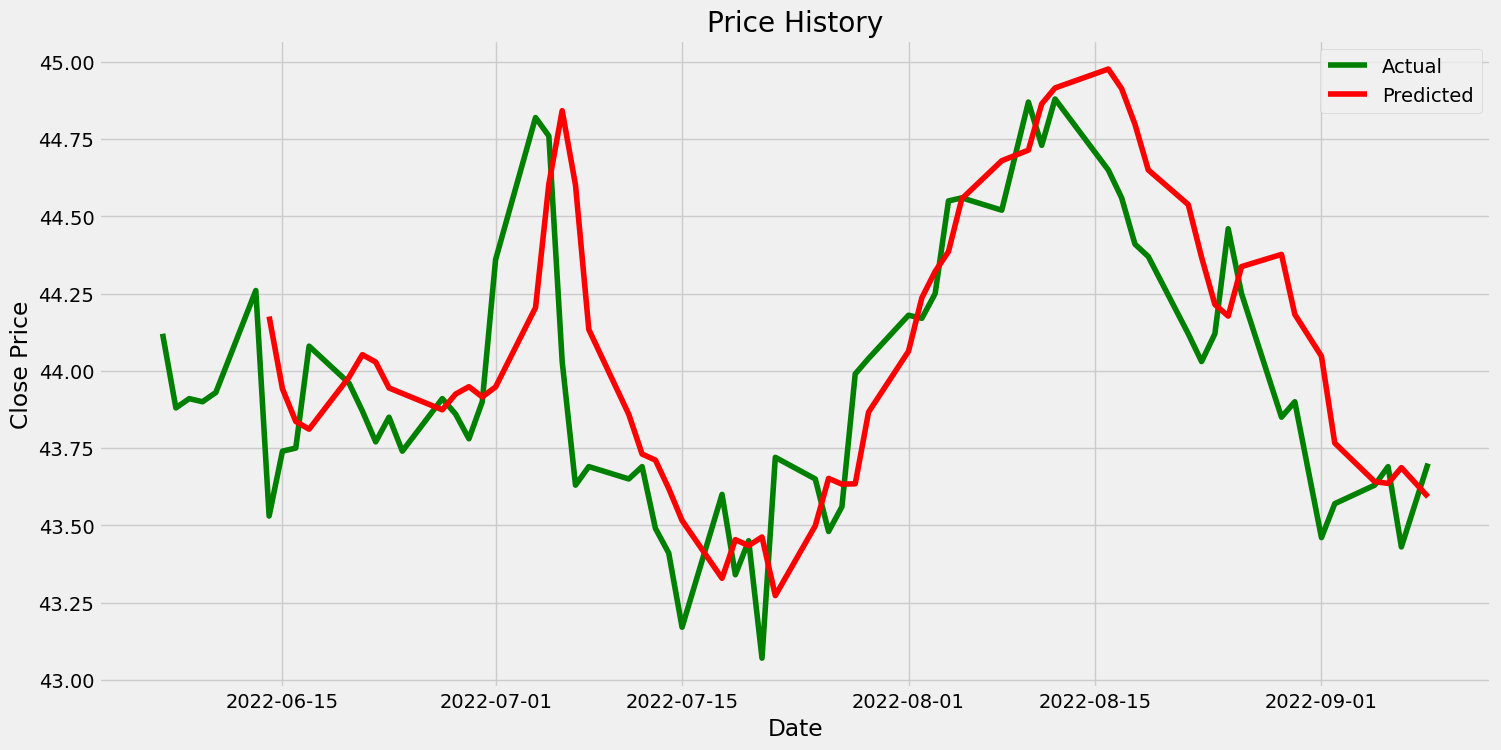

In [27]:
plt.figure(figsize = (16,8))
plt.title('Price History')
plt.plot(df.loc['2022-06-5':,'Close'],color= 'g')
plt.plot(valid['Predictions'], color = 'r')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend(["Actual", "Predicted"])
plt.show()

# API for Google Sheets
- As the dashboard for the stock analysis was done on Google Sheets , the data had to be stored to Google Sheets.

In [28]:
spreadsheet_key = '1hgH68VJuNU2o73rC18NYjqMuZ3ISuPhF45FENysYMjE'
wks_name = 'Master'
sh = gc.open_by_key(spreadsheet_key)

In [29]:
worksheet_list = sh.worksheets()
worksheet_list

[<Worksheet 'ICICI Prudential Gold ETF' id:1631294679>,
 <Worksheet 'HDFC GOLD ETF' id:752866263>,
 <Worksheet 'AXIS GOLD ETF' id:1042307528>,
 <Worksheet 'IDBI GOLD ETF' id:1854748226>,
 <Worksheet 'INVESCO INDIA GOLD ETF' id:636304532>,
 <Worksheet 'Rough Work' id:749992226>,
 <Worksheet 'Predicted Values' id:1745246579>,
 <Worksheet 'Sheet23' id:1279113395>]

# Storing Data to Google Sheets

In [30]:
for i in range(1,61):
    a = 'H' + str(i+2)
    worksheet_list[6].update_acell(a, valid.iloc[i-1,0])

In [31]:
x = valid.index

In [34]:
for i in range(1,61):
    a = 'G' + str(i+2)
    worksheet_list[6].update_acell(a,str(x[i-1]))

In [37]:
for i in range(0,60):
    a = 'I' + str(i+3)
    worksheet_list[6].update_acell(a, float(predictions[i]))

# Storing data to CSV file
- We can also store the data directly to excel file

In [38]:
valid.to_csv("C:/users/hp/axis_gold_pred.csv")